# "Give me some credit" challenge

## Library Imports

In [338]:
import pandas as pd
import numpy as np
import math
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier #Since the Dataset is Imbalanced, we go for boosting model.

print(os.listdir("../input"))

['sampleEntry.csv', 'cs-training.csv', 'cs-test.csv', 'Data Dictionary.xls']


## Importing Dataset

In [339]:
data = pd.read_csv('../input/cs-training.csv')
test_data = pd.read_csv('../input/cs-test.csv')

In [340]:
# Reading a glimps of the train data
data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [341]:
# Reading a glimps of the test data
test_data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


## Data cleaning

In [342]:
# changing the Unnamed column to id
data = data.rename(columns={'Unnamed: 0':'id'})
test_data = test_data.rename(columns={'Unnamed: 0':'id'})
data.columns

Index(['id', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [343]:
# changing the column names (replace '-' with "_") for better readability
for col in data.columns:
    old_col = col
    new_col = col.replace('-','_')
    data = data.rename(columns={old_col:new_col})
data.columns

Index(['id', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30_59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60_89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [344]:
# changing the column names (replace '-' with "_") for better readability
for col in test_data.columns:
    old_col = col
    new_col = col.replace('-','_')
    test_data = test_data.rename(columns={old_col:new_col})
test_data.columns

Index(['id', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30_59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60_89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [345]:
# sum of all the null values in each column
print(data.isnull().sum())

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30_59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60_89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


In [346]:
# filling null values
# replacing null values of 'MonthlyIncome' with the MEAN of available data
data['MonthlyIncome'].fillna(data['MonthlyIncome'].mean(),inplace=True)
# replacing null values of 'NumberOfDependents' with the MODE of available data
data['NumberOfDependents'].fillna(data['NumberOfDependents'].mode()[0], inplace=True)

In [347]:
data.describe()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.288045e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,6.600000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [348]:
print(test_data.isnull().sum())

id                                           0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30_59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60_89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64


In [349]:
# filling null values of the test data
# replacing null values of 'MonthlyIncome' with the MEAN of available data
test_data['MonthlyIncome'].fillna(test_data['MonthlyIncome'].mean(),inplace=True)
# replacing null values of 'NumberOfDependents' with the MODE of available data
test_data['NumberOfDependents'].fillna(test_data['NumberOfDependents'].mode()[0], inplace=True)

## Data exploration

In [350]:
# distinguishing between the features and target values
train_cols = [cols for cols in data.columns if cols not in ['SeriousDlqin2yrs','id']] # all of the features
out_col = ['SeriousDlqin2yrs']

In [351]:
data.describe()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.288045e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,6.600000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [352]:
# counting the ratio of classes
data['SeriousDlqin2yrs'].value_counts(normalize=True)

0    0.93316
1    0.06684
Name: SeriousDlqin2yrs, dtype: float64

this shows that our dataset is imbalanced and our positive class has less data samples. So in order to make data more realistic, we may delete some rows of data from the majority class to deal with outliers.

Text(0.5, 1.0, 'Distribution of stds of all features')

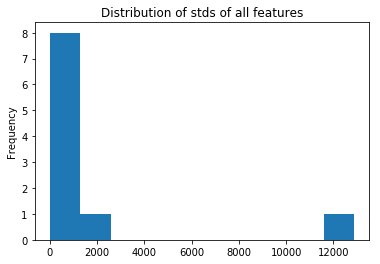

In [353]:
# 'Distribution of stds of all features
data[train_cols].std().plot('hist');
plt.title('Distribution of stds of all features')

Text(0.5, 1.0, 'Distribution of means of all columns')

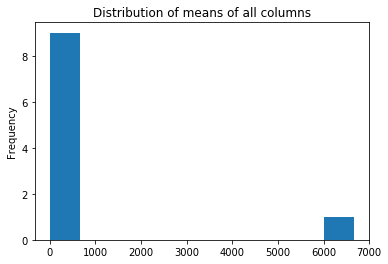

In [354]:
# Distribution of means of all columns
data[train_cols].mean().plot('hist');
plt.title('Distribution of means of all columns')

In [355]:
data.sort_values(by=['MonthlyIncome'], ascending=False)

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents
73763,73764,0,0.007328,52,0,0.001470,3008750.0,10,0,1,0,3.0
137140,137141,0,0.000000,68,0,0.002776,1794060.0,15,0,1,0,0.0
111365,111366,0,0.163856,44,0,0.004013,1560100.0,12,0,4,0,2.0
50640,50641,0,0.469025,44,1,0.004537,1072500.0,9,0,2,0,1.0
122543,122544,0,0.041599,55,0,0.000147,835040.0,8,0,0,0,0.0
123291,123292,0,0.226333,67,1,0.005570,730483.0,23,0,1,0,0.0
93564,93565,0,0.071628,50,0,0.008268,702500.0,12,0,4,0,2.0
96549,96550,0,0.064155,52,0,0.003698,699530.0,11,0,2,0,1.0
119136,119137,0,0.151329,49,0,0.001313,649587.0,8,0,0,1,3.0
37078,37079,0,0.000000,83,0,0.000000,629000.0,3,0,0,0,0.0


In [356]:
# removing rows with monthly income of more than 250'000, as they were so different than the distribution
# and also they were in the majority class (i.e., negative class)
data = data[data['MonthlyIncome']<250000]

In [357]:
# investigating the age validity
data.sort_values(by=['age'], ascending=True)

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents
65695,65696,0,1.000000,0,1,0.436927,6000.000000,6,0,2,0,2.0
100580,100581,0,1.000000,21,0,0.133245,1500.000000,1,0,0,0,0.0
58993,58994,0,1.000000,21,0,0.000000,600.000000,1,0,0,0,0.0
76664,76665,0,0.347652,21,0,0.012484,800.000000,1,0,0,0,0.0
67751,67752,0,1.000000,21,98,0.000000,400.000000,0,98,0,98,0.0
2791,2792,0,1.000000,21,0,0.000000,300.000000,1,0,0,0,0.0
138546,138547,1,1.000000,21,0,34.000000,6670.221237,1,0,0,0,0.0
58644,58645,0,1.000000,21,0,0.037023,2700.000000,1,0,0,0,0.0
122438,122439,0,1.000000,21,0,0.176044,550.000000,1,0,0,0,0.0
18526,18527,0,1.000000,21,98,0.000000,6670.221237,0,98,0,98,0.0


In [358]:
# removing the ages less than 20, cause there is one entry in data with age of 0
data = data[data['age']> 20]

In [359]:
data.describe()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents
count,149977.000000,149977.000000,149977.000000,149977.000000,149977.000000,149977.000000,149977.000000,149977.000000,149977.000000,149977.000000,149977.000000,149977.000000
mean,74998.836202,0.066844,6.049326,52.295305,0.421051,353.059206,6564.308405,8.452369,0.266014,1.018076,0.240410,0.737346
std,43301.892397,0.249752,249.774511,14.771791,4.193097,2037.970087,5461.821924,5.145762,4.169622,1.129060,4.155496,1.106993
min,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.000000,0.000000,0.029866,41.000000,0.000000,0.175153,3902.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,74998.000000,0.000000,0.154186,52.000000,0.000000,0.366546,6600.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112498.000000,0.000000,0.559087,63.000000,0.000000,0.868546,7397.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,237490.000000,58.000000,98.000000,54.000000,98.000000,20.000000


Text(0.5, 1.0, 'Distribution of stds of all features')

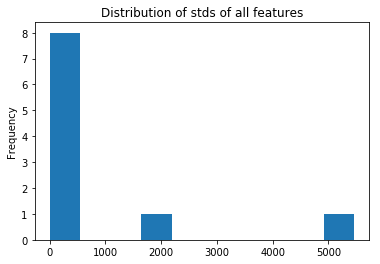

In [360]:
# 'Distribution of stds of all features
data[train_cols].std().plot('hist');
plt.title('Distribution of stds of all features')

Distributions of all features


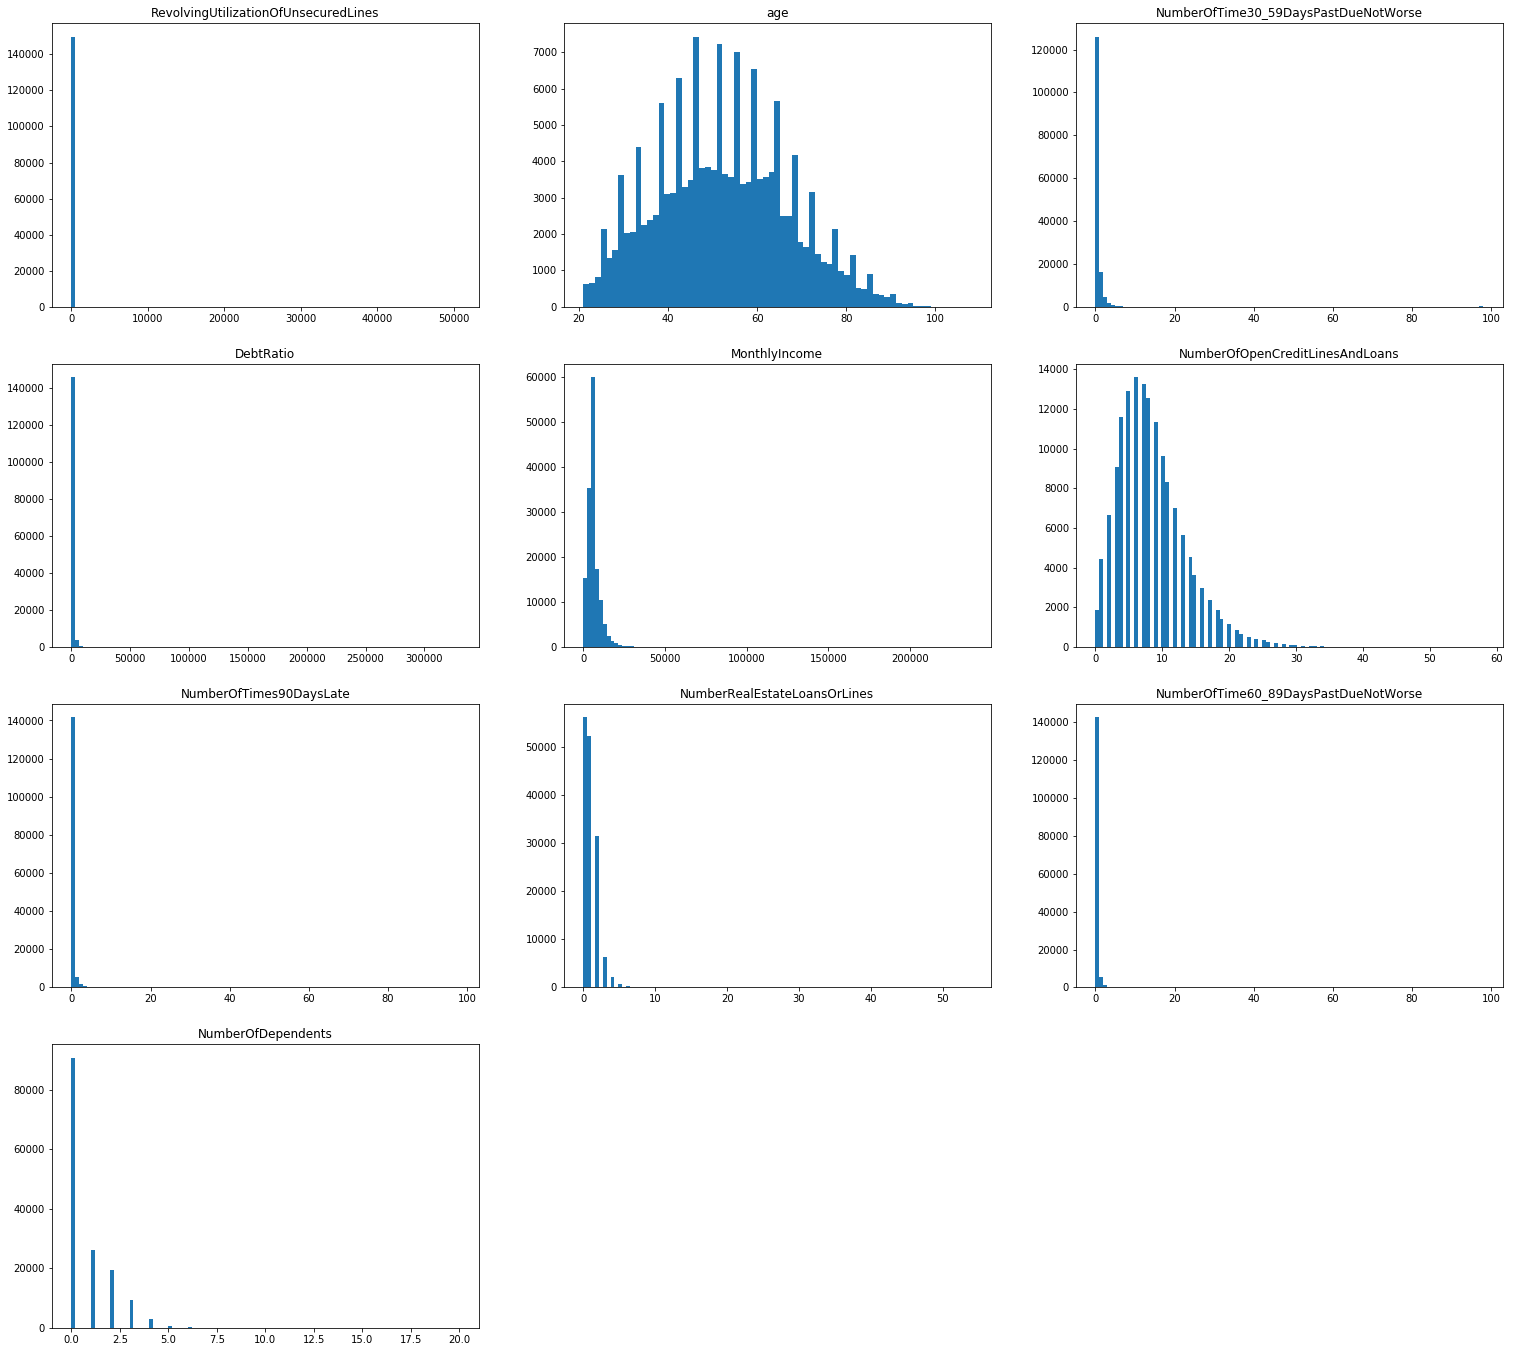

In [361]:
print('Distributions of all features')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train_cols)):
    plt.subplot(4, 3, i + 1)
    plt.hist(data[col],bins=np.arange(min(data[col]),max(data[col])+(min(data[col])+max(data[col]))/1000,
                                     (min(data[col])+max(data[col]))/100))
    plt.title(col)

In [362]:
# counting the ratio of classes
data['SeriousDlqin2yrs'].value_counts(normalize=True)

0    0.933156
1    0.066844
Name: SeriousDlqin2yrs, dtype: float64

###### From this overview we can see the following things:

* target is binary and has disbalance: 6.7% of samples belong to 1 class;
* couple of columns have high std (up to 5461)
* columns have a high range of means;

Let's have a look at correlations now!

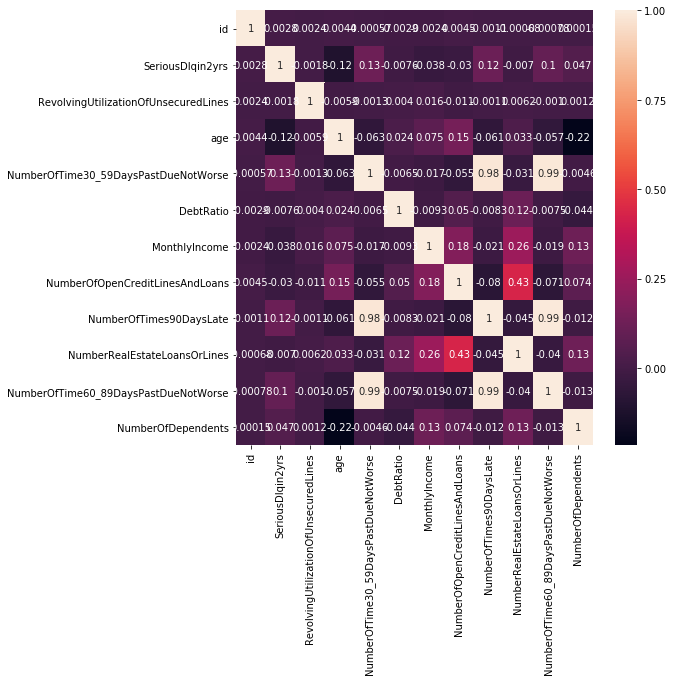

In [363]:
cor=data.corr()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True,ax=ax)

couple of columns are highly correlated. For example:

**('NumberOfTime30_59DaysPastDueNotWorse', 'NumberOfTime60_89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate')**

At the same time they have high correlation with the target value (i.e., **'SeriousDlqin2yrs'**)
Also **'age'** variable has a high correlation with the output

Histogram of the afforementioned patments is as below

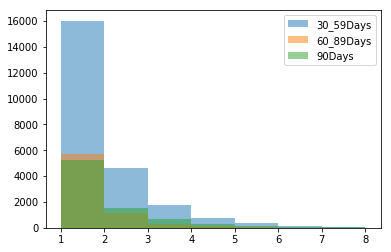

In [364]:
bins = np.linspace(1, 8, 8)
plt.hist(data['NumberOfTime30_59DaysPastDueNotWorse'].values, bins, alpha=0.5, label='30_59Days')
# plt.show()
plt.hist(data['NumberOfTime60_89DaysPastDueNotWorse'].values, bins, alpha=0.5, label='60_89Days')
# plt.show()
plt.hist(data['NumberOfTimes90DaysLate'].values, bins, alpha=0.5, label='90Days')
# plt.show()

plt.legend(loc='upper right')
plt.show()

## Feature engineering

Here we add some new features to our data.
 - The idea here is to group users based on their age, and add the mean value and std value of other columns as new features to them.

In [365]:
new_features1 = data.groupby('age').apply(lambda x: x[['MonthlyIncome',
                                                      'NumberOfTime30_59DaysPastDueNotWorse',
                                                      'NumberOfTime60_89DaysPastDueNotWorse',
                                                      'NumberOfTimes90DaysLate',
                                                      'DebtRatio',
                                                      'NumberOfOpenCreditLinesAndLoans',
                                                      'NumberRealEstateLoansOrLines',
                                                      'NumberOfDependents',
                                                      'RevolvingUtilizationOfUnsecuredLines',
                                                     ]].mean())
new_features2 = data.groupby('age').apply(lambda x: x[['MonthlyIncome',
                                                      'NumberOfTime30_59DaysPastDueNotWorse',
                                                      'NumberOfTime60_89DaysPastDueNotWorse',
                                                      'NumberOfTimes90DaysLate',
                                                      'DebtRatio',
                                                      'NumberOfOpenCreditLinesAndLoans',
                                                      'NumberRealEstateLoansOrLines',
                                                      'NumberOfDependents',
                                                      'RevolvingUtilizationOfUnsecuredLines',
                                                     ]].std())

new_features1.reset_index(inplace=True) # to put the age as column not an index
new_features2.reset_index(inplace=True) # to put the age as column not an index

In [366]:
# renaming these new features
new_features1.rename(columns={'MonthlyIncome':'mean_1',
                              'NumberOfTime30_59DaysPastDueNotWorse':'mean_2',
                              'NumberOfTime60_89DaysPastDueNotWorse':'mean_3',
                              'NumberOfTimes90DaysLate':'mean_4',
                              'DebtRatio':'mean_5',
                              'NumberOfOpenCreditLinesAndLoans':'mean_6',
                              'NumberRealEstateLoansOrLines':'mean_7',
                              'NumberOfDependents':'mean_8',
                              'RevolvingUtilizationOfUnsecuredLines':'mean_9'
                             },inplace=True)
new_features2.rename(columns={'MonthlyIncome':'std_1',
                              'NumberOfTime30_59DaysPastDueNotWorse':'std_2',
                              'NumberOfTime60_89DaysPastDueNotWorse':'std_3',
                              'NumberOfTimes90DaysLate':'std_4',
                              'DebtRatio':'std_5',
                              'NumberOfOpenCreditLinesAndLoans':'std_6',
                              'NumberRealEstateLoansOrLines':'std_7',
                              'NumberOfDependents':'std_8',
                              'RevolvingUtilizationOfUnsecuredLines':'std_9'
                             },inplace=True)

Adding the same features to the test set

In [367]:
new_features1 = test_data.groupby('age').apply(lambda x: x[['MonthlyIncome',
                                                      'NumberOfTime30_59DaysPastDueNotWorse',
                                                      'NumberOfTime60_89DaysPastDueNotWorse',
                                                      'NumberOfTimes90DaysLate',
                                                      'DebtRatio',
                                                      'NumberOfOpenCreditLinesAndLoans',
                                                      'NumberRealEstateLoansOrLines',
                                                      'NumberOfDependents',
                                                      'RevolvingUtilizationOfUnsecuredLines',
                                                     ]].mean())
new_features2 = test_data.groupby('age').apply(lambda x: x[['MonthlyIncome',
                                                      'NumberOfTime30_59DaysPastDueNotWorse',
                                                      'NumberOfTime60_89DaysPastDueNotWorse',
                                                      'NumberOfTimes90DaysLate',
                                                      'DebtRatio',
                                                      'NumberOfOpenCreditLinesAndLoans',
                                                      'NumberRealEstateLoansOrLines',
                                                      'NumberOfDependents',
                                                      'RevolvingUtilizationOfUnsecuredLines',
                                                     ]].std())

new_features1.reset_index(inplace=True) # to put the age as column not an index
new_features2.reset_index(inplace=True) # to put the age as column not an index

In [368]:
# renaming these new features for test set
new_features1.rename(columns={'MonthlyIncome':'mean_1',
                              'NumberOfTime30_59DaysPastDueNotWorse':'mean_2',
                              'NumberOfTime60_89DaysPastDueNotWorse':'mean_3',
                              'NumberOfTimes90DaysLate':'mean_4',
                              'DebtRatio':'mean_5',
                              'NumberOfOpenCreditLinesAndLoans':'mean_6',
                              'NumberRealEstateLoansOrLines':'mean_7',
                              'NumberOfDependents':'mean_8',
                              'RevolvingUtilizationOfUnsecuredLines':'mean_9'
                             },inplace=True)
new_features2.rename(columns={'MonthlyIncome':'std_1',
                              'NumberOfTime30_59DaysPastDueNotWorse':'std_2',
                              'NumberOfTime60_89DaysPastDueNotWorse':'std_3',
                              'NumberOfTimes90DaysLate':'std_4',
                              'DebtRatio':'std_5',
                              'NumberOfOpenCreditLinesAndLoans':'std_6',
                              'NumberRealEstateLoansOrLines':'std_7',
                              'NumberOfDependents':'std_8',
                              'RevolvingUtilizationOfUnsecuredLines':'std_9'
                             },inplace=True)

In [369]:
# merging new features into the train data
data = data.merge(new_features1,on=['age'],how='left')
data = data.merge(new_features2,on=['age'],how='left')

In [370]:
# merging new features into the test data
test_data = test_data.merge(new_features1,on=['age'],how='left')
test_data = test_data.merge(new_features2,on=['age'],how='left')

## Feature importance

Here we run a basic model of random forest on the data to extract the feature importance information

In [371]:
train_cols = [cols for cols in data.columns if cols not in ['SeriousDlqin2yrs','id']] # all of the features
X = data[train_cols]
y = data[out_col]

In [372]:
# Using a 3 fold cross validation with a base model of XGBClassifier to evaluate feature importance
kf = KFold(n_splits = 3, random_state = 415, shuffle = True)
base_outcomes = []
base_fold = 0
feature_importance_df = pd.DataFrame()
for train_index, val_index in kf.split(X):
    base_fold += 1
    base_predictions = np.zeros((X.values[val_index].shape[0],2))
    bagged_num = 7
    for i in range(bagged_num):
            base_model = XGBClassifier(n_estimators=100, tree_method='gpu_exact',seed=i)
            base_model.fit(X.values[train_index],y.values[train_index].reshape(len(train_index),)) 
            
            fold_importance_df = pd.DataFrame()
            fold_importance_df["Feature"] = train_cols
            fold_importance_df["importance"] = base_model.feature_importances_
            fold_importance_df["fold"] = base_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            
            base_preds = base_model.predict_proba(X.values[val_index])
            base_predictions += (base_preds/bagged_num)
    base_auc = roc_auc_score(y.values[val_index].reshape(len(val_index),), base_predictions[:,1])
    base_outcomes.append(base_auc)
    print("Fold {0} auc: {1}".format(base_fold, base_auc))
base_mean_outcome = np.mean(base_outcomes)
print("Mean Accuracy: {0}".format(base_mean_outcome))

Fold 1 auc: 0.8602511377865085
Fold 2 auc: 0.8667634779542832
Fold 3 auc: 0.8642759089015742
Mean Accuracy: 0.863763508214122


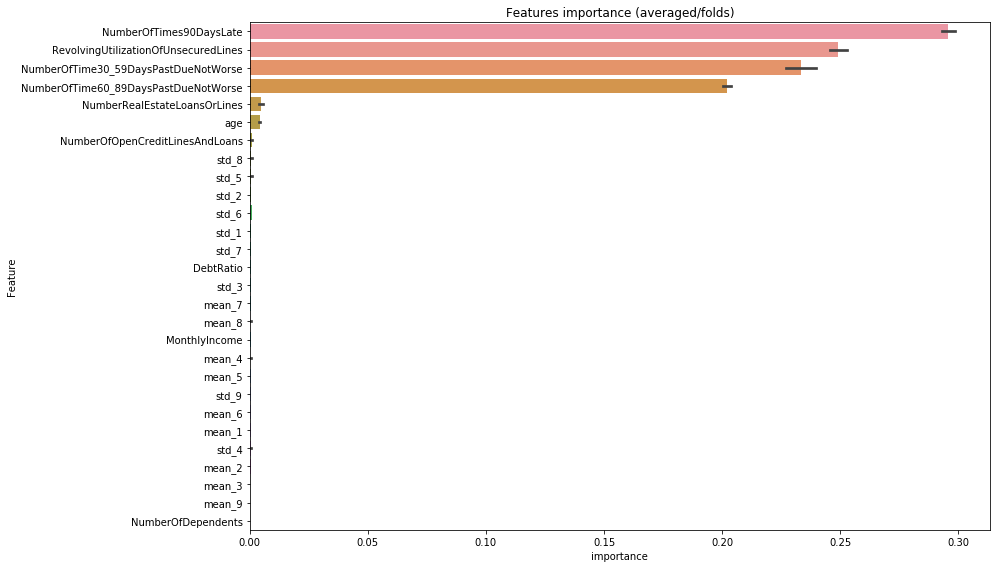

In [373]:
# Visualizing the feature importances
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,8))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

# Modeling

We used XGBoost Classifier as our model architecture


In [374]:
# using the top ten features for our training purposes
train_cols = best_features.sort_values(by="importance",ascending=False).Feature.unique()[:9]
train_cols = np.append(train_cols,['MonthlyIncome','NumberOfDependents','DebtRatio',
                                  'NumberOfOpenCreditLinesAndLoans']) # We also add the original set of columns for training
out_col = ['SeriousDlqin2yrs']

In [375]:
# Building X and y for training and testing
X = data[train_cols]
y = data[out_col]

### Using cross_validation with XGBoost for hyperparameter tunning

In [376]:
# We used 3 folds for cross validation, and by examining the std of scores of different
# folds, 3 was selected as an appropriate number for cross validation folds
kf = KFold(n_splits = 3, random_state = 415, shuffle = True)

In [377]:
#------------------------Build XGB Model-----------------------
outcomes = []
fold = 0
for train_index, val_index in kf.split(X):
    fold += 1
    xgb_predictions = np.zeros((X.values[val_index].shape[0],2))
    bagged_num = 7
    for i in range(bagged_num):
            xgb_model = XGBClassifier(n_estimators=250, tree_method='gpu_exact',
                                      booster='gbtree', reg_alpha=2,
                                      reg_lambda=3, seed=i, subsample=0.8)
            xgb_model.fit(X.values[train_index],y.values[train_index].reshape(len(train_index),))  
            preds = xgb_model.predict_proba(X.values[val_index])
            xgb_predictions += (preds/bagged_num)
    xgb_auc = roc_auc_score(y.values[val_index].reshape(len(val_index),), xgb_predictions[:,1])
    outcomes.append(xgb_auc)
    print("Fold {0} auc: {1}".format(fold, xgb_auc))
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome))

Fold 1 auc: 0.8620204140583966
Fold 2 auc: 0.8687077865665638
Fold 3 auc: 0.8654153811622681
Mean Accuracy: 0.8653811939290761


## Training our model on the whole train set

In [378]:
X_test = test_data[train_cols]

In [379]:
# XGB model
xgb_predictions = np.zeros((X_test.values.shape[0],2))
bagged_num = 7
for i in range(bagged_num):
        xgb_model = XGBClassifier(n_estimators=250, tree_method='gpu_exact',
                                  booster='gbtree', reg_alpha=2,
                                  reg_lambda=3, seed=i, subsample=0.8)
        xgb_model.fit(X.values,y.values.reshape(len(y),))  
        preds = xgb_model.predict_proba(X_test.values)
        xgb_predictions += (preds/bagged_num)

In [380]:
results = pd.read_csv('../input/sampleEntry.csv')

In [381]:
results['Probability'] = xgb_predictions[:,1]

In [382]:
results.set_index('Id',inplace=True)

In [383]:
# results.set_index('Id',inplace=True)
results.to_csv('submission.csv',index='Id')